In [22]:
#imports
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import linear_model
from sklearn.feature_selection import RFE

#model metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

#cross validation
from sklearn.model_selection import train_test_split

In [3]:
#data
rawData = pd.read_csv('default of credit card clients.csv', header =1)
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#preprocessing

rawData = rawData.drop(['ID'], axis=1)
rawData.rename(columns={'default payment next month': 'default'}, inplace=True)
rawData['SEX'] = rawData.SEX.astype('category')
rawData['EDUCATION'] = rawData.EDUCATION.astype('category')
rawData['MARRIAGE'] = rawData.MARRIAGE.astype('category')
rawData['PAY_0'] = rawData.PAY_0.astype('category')
rawData['PAY_2'] = rawData.PAY_2.astype('category')
rawData['PAY_3'] = rawData.PAY_3.astype('category')
rawData['PAY_4'] = rawData.PAY_4.astype('category')
rawData['PAY_5'] = rawData.PAY_5.astype('category')
rawData['PAY_6'] = rawData.PAY_6.astype('category')
rawData['default'] = rawData.default.astype('category')

credit_DF = rawData

credit_DF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null int64
PAY_0        30000 non-null category
PAY_2        30000 non-null category
PAY_3        30000 non-null category
PAY_4        30000 non-null category
PAY_5        30000 non-null category
PAY_6        30000 non-null category
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null category
dtypes: category(10), int64(14)
memory usage:

In [5]:
# class distribution
print(credit_DF.groupby('default').size())

default
0    23364
1     6636
dtype: int64


In [8]:
# Sampling - 30% of data
seed = 7
credit_DF_30p = credit_DF.sample(frac = 0.3, random_state = seed)

In [9]:
#features
features = credit_DF_30p.iloc[:,0:23]
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1252,20000,2,1,2,22,0,0,0,0,0,...,16262,16749,13764,18732,1600,1550,1000,1000,5283,0
10444,10000,2,2,1,22,-1,-1,-1,0,0,...,9159,9363,8160,7552,390,9159,700,279,1000,800
8994,50000,1,1,2,30,0,0,2,2,2,...,45393,49351,45473,48595,6012,10,8212,1200,4008,4407
7463,360000,1,3,2,34,-1,-1,-1,-1,-1,...,944,1219,2216,1440,1937,944,1219,2216,2000,648
1910,360000,1,1,1,38,-1,-1,-1,-1,-1,...,390,390,390,390,0,390,390,390,390,390


In [10]:
# Dependent variable
depVar = credit_DF_30p['default']

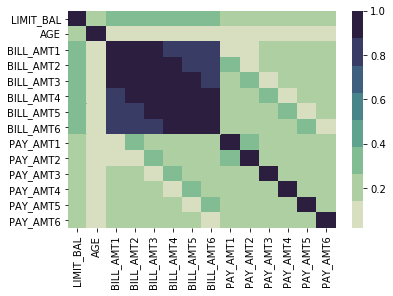

In [26]:
# plot correlation matrix
correlations = credit_DF.corr()
sns.heatmap(correlations, 
        xticklabels=correlations.columns,
        yticklabels=correlations.columns, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75))

# The monthly Billing amount have high correlation

In [31]:
# Identify highly correlated features
correlations =  correlations.abs()
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop


['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

In [32]:
# Remove highly correlated features > 0.9
features_CORR = features[features.columns.difference(to_drop)]
features_CORR.head()

,AGE,BILL_AMT1,EDUCATION,LIMIT_BAL,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX
1252,22,15829,1,20000,2,0,0,0,0,0,0,1600,1550,1000,1000,5283,0,2
10444,22,390,2,10000,1,-1,-1,-1,0,0,0,390,9159,700,279,1000,800,2
8994,30,45948,1,50000,2,0,0,2,2,2,0,6012,10,8212,1200,4008,4407,1
7463,34,3821,3,360000,2,-1,-1,-1,-1,-1,-1,1937,944,1219,2216,2000,648,1
1910,38,780,1,360000,1,-1,-1,-1,-1,-1,-1,0,390,390,390,390,390,1


In [35]:
# Feature Engineering with RFE
model = RandomForestClassifier(n_estimators=100)
rfe = RFE(model, 10)
fit = rfe.fit(features, depVar)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 10
Selected Features: [ True False False False  True  True False False False False False  True
  True  True  True  True  True  True False False False False False]
Feature Ranking: [ 1 14 11 13  1  1  6  8  9 10 12  1  1  1  1  1  1  1  2  3  7  5  4]


In [45]:
# RFE selected Features
selected = fit.get_support(1) #the most important features
features_RFE = features[features.columns[selected]]
features_RFE.head()

,LIMIT_BAL,AGE,PAY_0,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1
1252,20000,22,0,15829,15299,16262,16749,13764,18732,1600
10444,10000,22,-1,390,390,9159,9363,8160,7552,390
8994,50000,30,0,45948,50813,45393,49351,45473,48595,6012
7463,360000,34,-1,3821,1937,944,1219,2216,1440,1937
1910,360000,38,-1,780,0,390,390,390,390,0


In [54]:
# Train and Test sets - 75/25 split
test_size = 0.25 
seed = 7 
X_train, X_test, Y_train, Y_test = train_test_split(features, depVar, test_size=test_size, random_state=seed)
#Train/ Test set size
print('The number of observations in the training set are:',str(len(X_train.index)))
print('The number of observations in the test set are:',str(len(X_test.index)))

The number of observations in the training set are: 6750
The number of observations in the test set are: 2250


In [55]:
# Prepare models
models = [] 
models.append(('LR', LogisticRegression(solver = 'liblinear'))) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', svm.SVC(gamma='scale')))
models.append(('RF', RandomForestClassifier(n_estimators=100))) 


In [56]:
# evaluate each model in turn 
results = [] 
names = [] 
scoring = 'accuracy' 
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)


LR: 0.777481 (0.020017)
KNN: 0.745926 (0.022944)
SVM: 0.775704 (0.020605)
RF: 0.817037 (0.015112)


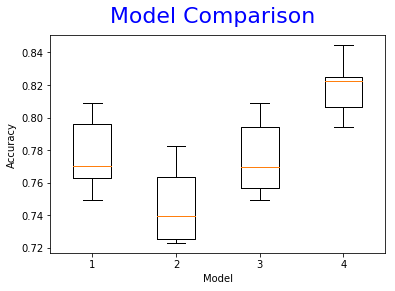

In [78]:
#algorithm comparison 
fig = plt.figure() 
fig.suptitle('Model Comparison',fontsize=22, color='blue') 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()


# Algorithms comparison
Best accuracy with Random Forest OOB


1. OOB
LR: 0.777481 (0.020017)
KNN: 0.745926 (0.022944)
SVM: 0.775704 (0.020605)
RF: 0.817037 (0.015112)

2. Correlated Features Removed
LR: 0.777630 (0.019969)
KNN: 0.744889 (0.024224)
SVM: 0.774370 (0.021004)
RF: 0.815704 (0.014198)

3. RFE Selected Features
LR: 0.777037 (0.019757)
KNN: 0.736296 (0.019225)
SVM: 0.775556 (0.021090)
RF: 0.813778 (0.012916)



In [16]:
# Tune KNN
neighbors = [1,10,20,50,100]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.776593 using {'n_neighbors': 100}
0.701333 (0.019398) with: {'n_neighbors': 1}
0.766815 (0.019779) with: {'n_neighbors': 10}
0.771852 (0.019854) with: {'n_neighbors': 20}
0.774667 (0.017697) with: {'n_neighbors': 50}
0.776593 (0.018725) with: {'n_neighbors': 100}


In [17]:
# Tune SVM
c_values = [0.1, 1.0, 10]
kernel_values = ['linear']
param_grid = dict(C = c_values)  #, kernel=kernel_values)
model = svm.SVC(gamma='scale')
kfold = KFold(n_splits=3, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.777630 using {'C': 0.1}
0.777630 (0.011128) with: {'C': 0.1}
0.776444 (0.011776) with: {'C': 1.0}
0.774222 (0.010983) with: {'C': 10}


In [57]:
# Tune RF
n_estimators_values = [50, 100, 200, 500, 1000]
max_features_values = [2,3,4]
param_grid = dict(n_estimators = n_estimators_values, max_features = max_features_values)
model = RandomForestClassifier()
kfold = KFold(n_splits=10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.815704 using {'max_features': 3, 'n_estimators': 1000}
0.810963 (0.014549) with: {'max_features': 2, 'n_estimators': 50}
0.812148 (0.014915) with: {'max_features': 2, 'n_estimators': 100}
0.812444 (0.016014) with: {'max_features': 2, 'n_estimators': 200}
0.814370 (0.014395) with: {'max_features': 2, 'n_estimators': 500}
0.813481 (0.015245) with: {'max_features': 2, 'n_estimators': 1000}
0.815407 (0.014290) with: {'max_features': 3, 'n_estimators': 50}
0.812741 (0.014228) with: {'max_features': 3, 'n_estimators': 100}
0.814815 (0.014379) with: {'max_features': 3, 'n_estimators': 200}
0.814519 (0.013510) with: {'max_features': 3, 'n_estimators': 500}
0.815704 (0.013549) with: {'max_features': 3, 'n_estimators': 1000}
0.813630 (0.015871) with: {'max_features': 4, 'n_estimators': 50}
0.812593 (0.013727) with: {'max_features': 4, 'n_estimators': 100}
0.814667 (0.012735) with: {'max_features': 4, 'n_estimators': 200}
0.815407 (0.014877) with: {'max_features': 4, 'n_estimators': 500}


In [19]:
# Tune LR
C_values = [0.01,0.1,1,10,100]
penalty_values = ['l1', 'l2']
param_grid = dict(penalty = penalty_values, C = C_values)
model = LogisticRegression(solver = 'liblinear')
kfold = KFold(n_splits=3, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.807852 using {'C': 10, 'penalty': 'l1'}
0.797778 (0.009539) with: {'C': 0.01, 'penalty': 'l1'}
0.777481 (0.010973) with: {'C': 0.01, 'penalty': 'l2'}
0.806519 (0.005900) with: {'C': 0.1, 'penalty': 'l1'}
0.777481 (0.010973) with: {'C': 0.1, 'penalty': 'l2'}
0.807407 (0.006032) with: {'C': 1, 'penalty': 'l1'}
0.777481 (0.010973) with: {'C': 1, 'penalty': 'l2'}
0.807852 (0.005900) with: {'C': 10, 'penalty': 'l1'}
0.777481 (0.010973) with: {'C': 10, 'penalty': 'l2'}
0.807852 (0.006032) with: {'C': 100, 'penalty': 'l1'}
0.777481 (0.010973) with: {'C': 100, 'penalty': 'l2'}


In [63]:
# Finalize Model: Random forest

# prepare the model

model = RandomForestClassifier(max_features = 3, n_estimators = 1000)
model.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
# make predictions
predictions = model.predict(X_test)


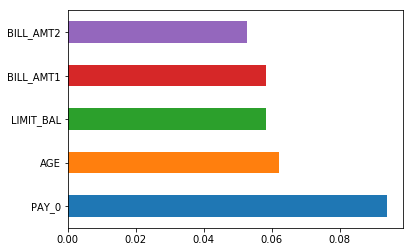

In [70]:
# Feature Importance
# print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index= features.columns)
feat_importances.nlargest(5).plot(kind='barh')

In [71]:
# summarize the fit of the model
print('Accuracy: %.2f' % accuracy_score(Y_test, predictions))
print('Kappa: %.2f' % cohen_kappa_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy: 0.81
Kappa: 0.33
[[1654  116]
 [ 313  167]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      1770
           1       0.59      0.35      0.44       480

   micro avg       0.81      0.81      0.81      2250
   macro avg       0.72      0.64      0.66      2250
weighted avg       0.79      0.81      0.79      2250

